# Prep

This blocks installs all the neccesary dependancies, and imports the relevant files

* import tf.models
* install relevant packages 
* import standard dataset
* import additional dataset
* define helper functions


In [ ]:
!pip -q install tf_slim
!pip -q install pycocotools

     |████████████████████████████████| 358kB 3.4MB/s 


In [ ]:
# Import tensorflow.models into the current directory
import os 
import pathlib
import sys

if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('...')
elif not pathlib.Path('models').exists():
  print('Downloading from github ... ')
  !git clone --depth 1 https://github.com/tensorflow/models

os.environ['PYTHONPATH'] += ":/content/models"
sys.path.append("/content/models")

Cloning into 'models'...
remote: Enumerating objects: 2017, done.
remote: Counting objects: 100% (2017/2017), done.
remote: Compressing objects: 100% (1756/1756), done.
remote: Total 2017 (delta 459), reused 858 (delta 238), pack-reused 0
Receiving objects: 100% (2017/2017), 30.20 MiB | 27.78 MiB/s, done.
Resolving deltas: 100% (459/459), done.


In [ ]:
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.

In [ ]:
%%bash 
cd models/research
pip -q install .

In [ ]:
# Download data from drive into cwd

if 'Data' not in os.listdir():
  !cp "/content/drive/My Drive/ML/waste_detection/Data/med_res_2.zip" .
  !unzip -q med_res_2.zip -d Data
  # Remove the zip file 
  !rm med_res_2.zip

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import shutil
import json
import random
import re
import io
import imageio
import cv2
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from tqdm import tqdm 
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline


In [ ]:
# Helper functions 
def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path.

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load images into numpy arrays 
def image_to_np(dir, w, h):
  output = [None] * len(os.listdir(dir))
  i = 0
  for file in tqdm(os.listdir(dir)):
    img = load_image_into_numpy_array(dir + file)
    res = cv2.resize(img, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
    output[i] = res
    i += 1
  return output

# Utilizes the visualization_utils
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    threshold = 0.8):
  """Wrapper function to visualize detections.

  Args:
    image_np: uint8 numpy array with shape (img_height, img_width, 3)
    boxes: a numpy array of shape [N, 4]
    classes: a numpy array of shape [N]. Note that class indices are 1-based,
      and match the keys in the label map.
    scores: a numpy array of shape [N] or None.  If scores=None, then
      this function assumes that the boxes to be plotted are groundtruth
      boxes and plot all boxes as black with no classes or scores.
    category_index: a dict containing category dictionaries (each holding
      category index `id` and category name `name`) keyed by category indices.
    figsize: size for the figure.
    image_name: a name for the image file.
  """
  image_np_with_annotations = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_annotations,
      boxes,
      classes,
      scores,
      category_index,
      use_normalized_coordinates=True,
      min_score_thresh=threshold)
  if image_name:
    plt.imsave(image_name, image_np_with_annotations)
  else:
    plt.imshow(image_np_with_annotations)
  
def split_data(SOURCE, TRAIN_DIR, TEST_DIR, SPLIT_PERCENT, seed = False, FILENAMES=None):

  # Get a list of image names

  if FILENAMES == None:
    files = []
    for filename in os.listdir(SOURCE):
        filepath = SOURCE + filename
        if filepath.endswith('.jpg'):
            files.append(filename)
  else:
    files = FILENAMES

  # Define test and train length
  train_length = int(len(files) * SPLIT_PERCENT)
  test_length = int(len(files)-train_length)

  # Shuffle and split
  # if seed:
  random.seed(1)
  random.shuffle(files)
  training_set = files[0:train_length]
  testing_set = files[-test_length:]

  # move the files
  for filename in training_set:
      os.replace(SOURCE+filename, TRAIN_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TRAIN_DIR+filename)
  for filename in testing_set:
      os.replace(SOURCE+filename, TEST_DIR + filename)
      # shutil.copyfile(SOURCE+filename, TEST_DIR+filename)


# Move
This block moves the images in place and stores the data in memory

* split images into train and test folders
* all json files are stored in the same folder
* normalize boxes
* store all images as numpy arrays into memory
* convert np arrays into tensors, to be passed into model

In [ ]:
# Split data into train and test folders

def extract(label, category):
  # remove this when label is fixed
  # if category not in label:
  #   if category == 'gas_bottles_or_cylinders':
  #     print('found typo')
  #     category = 'gas_bottles_or_cyclinders'
  if label[category] is not None:
    return np.array(label[category])

current_dir = os.getcwd()
image_path = os.path.join(current_dir, 'Data/images')
label_path = os.path.join(current_dir, 'Data/bboxes_d')

label_names = {1: 'black_bag_waste'}

valid_jpgs = []

# Select only samples that contain classes from above:
for filepath in os.listdir(image_path):
  filename = filepath.split('/')[-1]
  if filename.endswith('.jpg'):
    json_file = os.path.join(label_path, filename[:-4]+'_bboxs_d.json')
    with open(json_file, 'r') as file:
      annotation = json.load(file)
      filtered_annotation = np.array([extract(annotation, label_names[i]) for i in label_names])
      for Class in filtered_annotation:
        # Only append if not empty
        if Class is not None:
          valid_jpgs.append(filename)
          break
        # print(annotation[Class])

print(len(os.listdir(image_path)))
print(len(valid_jpgs))

67
0


In [ ]:
try: 
  os.mkdir(image_path + '/train')
  os.mkdir(image_path + '/test')
  print('Created train and test directories')
except:
  pass

train_dir = os.path.join(image_path, 'train/')
test_dir = os.path.join(image_path, 'test/')

# Execute moving files
try:
  split_data(image_path+'/', train_dir, test_dir, 0.9, seed=True, FILENAMES = valid_jpgs)
except OSError:
  print('error raised')
  pass

print('train folder: {}, test folder: {}'.format(len(os.listdir(train_dir)), len(os.listdir(test_dir))))

Created train and test directories
train folder: 141, test folder: 16


In [ ]:
# Load label json files into numpy arrays 

def json_to_np(dir):
  output_boxes = []
  output_classes = []
  output_difficults = []

  for i, file in enumerate(os.listdir(dir)):
  #     # Get name of the file
      label_file = os.path.join(label_path, file[:-4]+'_bboxs_d.json')
      with open(label_file, 'r') as file:
        label = json.load(file)

      filtered_annotation = np.array([extract(label, label_names[i]) for i in label_names])

      boxes = np.array([[0, 0, 0, 0]])
      classes = np.array([])
      difficults = np.array([])

      for index, category in enumerate(filtered_annotation):
        if category is not None:
          for box in category:
            boxes = np.vstack([boxes, box[0]])
            classes = np.append(classes, np.array([1]))
            difficults = np.append(difficults, box[1])

      output_boxes.append(boxes[1:].astype('float'))
      output_classes.append(classes.astype('int32'))
      output_difficults.append(difficults.astype('int32'))

  return output_boxes, output_classes, output_difficults

y_train_boxes, y_train_classes, y_train_difficults = json_to_np(train_dir)
y_test_boxes, y_test_classes, y_test_difficults = json_to_np(test_dir)

num = 0
for boxes in y_train_boxes:
  num += len(boxes)
print(num)

520


In [ ]:
print(y_test_boxes[1])
print(y_test_classes[1])
print(y_test_difficults[1])

[[0.16140777 0.42147436 0.25970874 0.53846154]
 [0.45024272 0.19871795 0.5631068  0.32532051]
 [0.36407767 0.13621795 0.43932039 0.21794872]
 [0.1868932  0.57211538 0.38956311 0.80929487]
 [0.39320388 0.53044872 0.48179612 0.75      ]
 [0.43203883 0.44230769 0.66383495 0.71634615]
 [0.62985437 0.41346154 0.83859223 0.66025641]
 [0.81067961 0.57051282 0.96480583 0.75320513]
 [0.35315534 0.76442308 0.4684466  0.91185897]]
[1 1 1 1 1 1 1 1 1]
[0 0 1 0 0 0 0 0 1]


In [ ]:
# Normalize the labels 

# width: 420, height: 312
# Data format right now: [xmin, ymin, xmax, ymax]
# Target format         : [ymin, xmin, ymax, xmax]

orig_width = 640
orig_height = 640

target_width = orig_width
target_height = orig_height

def normalize_boxes(labels, width, height):
  for label in labels:
    for box in label:
      # box[0] /= width
      # box[2] /= width
      # box[1] /= height
      # box[3] /= height

      box[0], box[1], box[2], box[3] = box[1], box[0], box[3], box[2]
  return labels

y_train_boxes = normalize_boxes(y_train_boxes, orig_width, orig_height)
y_test_boxes = normalize_boxes(y_test_boxes, orig_width, orig_height)

print(y_test_boxes[1])

[[0.42147436 0.16140777 0.53846154 0.25970874]
 [0.19871795 0.45024272 0.32532051 0.5631068 ]
 [0.13621795 0.36407767 0.21794872 0.43932039]
 [0.57211538 0.1868932  0.80929487 0.38956311]
 [0.53044872 0.39320388 0.75       0.48179612]
 [0.44230769 0.43203883 0.71634615 0.66383495]
 [0.41346154 0.62985437 0.66025641 0.83859223]
 [0.57051282 0.81067961 0.75320513 0.96480583]
 [0.76442308 0.35315534 0.91185897 0.4684466 ]]


In [ ]:
# Filtering to trivial boxes only:

temp_difficults_test = []
for i, sample in enumerate(y_test_difficults):
  temp_index = []
  for j, diff in enumerate(sample):
    if diff == 1:
      temp_index.append(j)
  temp_difficults_test.append(temp_index)

temp_difficults_train = []
for i, sample in enumerate(y_train_difficults):
  temp_index = []
  for j, diff in enumerate(sample):
    if diff == 1:
      temp_index.append(j)
  temp_difficults_train.append(temp_index)

# temp_difficults[1]

y_test_boxes_trivial = []
y_test_classes_trivial = []

for i, temp_difficult in enumerate(temp_difficults_test):
  y_test_boxes_trivial.append(np.delete(y_test_boxes[i], temp_difficult, 0))
  y_test_classes_trivial.append(np.delete(y_test_classes[i], temp_difficult, 0))

y_train_boxes_trivial = []
y_train_classes_trivial = []

for i, temp_difficult in enumerate(temp_difficults_train):
  y_train_boxes_trivial.append(np.delete(y_train_boxes[i], temp_difficult, 0))
  y_train_classes_trivial.append(np.delete(y_train_classes[i], temp_difficult, 0))

num = 0
for boxes in y_train_boxes_trivial:
  num += len(boxes)
print(num)

389


In [ ]:
x_train_np = image_to_np(train_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_train_np)} training images')

x_test_np = image_to_np(test_dir, target_width, target_height)
print(f'\n Appended and resized {len(x_test_np)} training images')

# before: 92s

  0%|          | 0/16 [00:00<?, ?it/s]


 Appended and resized 141 training images


100%|██████████| 16/16 [00:07<00:00,  2.00it/s]


 Appended and resized 16 training images


In [ ]:
# Prepping data, converting np arrays into tensors 
# Note: this needs to be updated for multi-class

def np_to_tensors(image_nps, box_nps, class_nps):
  image_tensors = []
  box_tensors = []
  classes_one_hot_tensors = []

  for (image_np, box_np, class_np) in zip(image_nps, box_nps, class_nps):
    image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        image_np, dtype=tf.float32), axis=0))
    box_tensors.append(tf.convert_to_tensor(box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(class_np - label_id_offset, dtype=np.int32)
    classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

  return image_tensors, box_tensors, classes_one_hot_tensors

binbag_class_id = 1

num_classes = 1

category_index = {}
for i in label_names:
  category_index[i] = {'id': i, 'name': label_names[i]}

label_id_offset = 1

train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors = np_to_tensors(x_train_np, y_train_boxes, y_train_classes)
test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors = np_to_tensors(x_test_np, y_test_boxes, y_test_classes)

print('Done prepping data.')

Done prepping data.


In [ ]:
# plt.rcParams['figure.figsize'] = [14, 7]

# # temp_img_tensors = tf.math.scalar_mul(1/255, train_image_tensors[0])

# bright_image = tf.image.random_brightness(train_image_tensors[0], 0.2)

# # hue_image = tf.image.random_hue(train_image_tensors[0][0], 0.2)
# hue_image = tf.image.random_hue(bright_image, 0.1)

# contrast_image = tf.image.random_contrast(hue_image, 0.8, 1.2)

# plt.subplot(1, 4, 1)
# plt.imshow(train_image_tensors[0][0].numpy())

# plt.subplot(1, 4, 2)
# plt.imshow(bright_image[0].numpy())

# plt.subplot(1, 4, 3)
# plt.imshow(contrast_image[0].numpy())

# plt.subplot(1, 4, 4)
# plt.imshow(hue_image[0].numpy())

In [ ]:
# train_image_tensors[0][0]

In [ ]:
# Optional: visulize images
from skimage.transform import resize

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

plt.figure(figsize=(30, 15))
for i in range(6):
  offset = 0
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+ offset], dsize=(421, 320), interpolation=cv2.INTER_CUBIC),
      y_test_boxes_trivial[i+ offset],
      y_test_classes_trivial[i+ offset],
      np.ones(shape=[y_test_boxes[i+ offset].shape[0]], dtype=np.float16),
      category_index)
plt.axis('off')

plt.show()



Output hidden; open in https://colab.research.google.com to view.

# Load Config

This block creates the model metaArch, and loads untrained weights

* download weights from tensorflow.models
* loads the config file from '/models/research/object_detection/configs'
* restores weights and create a checkpoint instance



In [ ]:
if 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8' not in os.listdir():
  !wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz 
  !tar -xf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
  !rm ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
# !mv ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2020-08-29 14:54:33--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 173.194.197.128, 2607:f8b0:4001:c1b::80
Connecting to download.tensorflow.org (download.tensorflow.org)|173.194.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M   129MB/s    in 0.2s    

2020-08-29 14:54:33 (129 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]



In [ ]:
# Configuring and creating the detection model (weight's are not loaded here)

num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.config'
checkpoint_path = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt'

raw_checkpoint = checkpoint_path + '-0'

# Load pipeline config and build a detection model architecture (only need to be ran once)

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config = model_config, is_training=True
)


In [ ]:
# [i.name for i in detection_model.trainable_variables]
# len(detection_model.trainable_variables)

In [ ]:
# Restore weights (original weights)

def restore_weights(ckpt_path, restore_all=True):

  print(f'restoring weights from {str(ckpt_path)}')

  if restore_all:
    ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
    ckpt.restore(ckpt_path).expect_partial()
  
  else:
    fake_box_predictor = tf.compat.v2.train.Checkpoint(
      _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
      _box_prediction_head=detection_model._box_predictor._box_prediction_head
      )

    fake_model = tf.compat.v2.train.Checkpoint(
                _feature_extractor=detection_model._feature_extractor,
                _box_predictor=fake_box_predictor)
  
    ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
    ckpt.restore(ckpt_path).expect_partial()

  # Run model through a dummy image so that variables are created
  image, shapes = detection_model.preprocess(tf.zeros([1, target_height, target_width, 3]))
  prediction_dict = detection_model.predict(image, shapes)
  _ = detection_model.postprocess(prediction_dict, shapes)
  print('Weights restored!')

  return ckpt

# Initialize ckpt
ckpt = restore_weights(raw_checkpoint, restore_all=False)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0
Weights restored!


# Functions
This block contains the following functions:

* step function (for both training and evaluating)
* layer extraction function
* main training block (given hyperparameters)

### get_model_train_step_function()


In [ ]:
# Set up forward + backward pass for a single train step.
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
  """Get a tf.function for training step."""

  # @tf.function
  def train_step_fn(image_tensors,
                    groundtruth_boxes_list,
                    groundtruth_classes_list,
                    backprop = True):
    """A single training iteration.

    Args:
      image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
        Note that the height and width can vary across images, as they are
        reshaped within this function to be 640x640.
      groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
        tf.float32 representing groundtruth boxes for each image in the batch.
      groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
        with type tf.float32 representing groundtruth boxes for each image in
        the batch.

    Returns:
      A scalar tensor representing the total loss for the input batch.
    """
    shapes = tf.constant(len(image_tensors) * [[target_height, target_width, 3]], dtype=tf.int32)

    model.provide_groundtruth(
        groundtruth_boxes_list=groundtruth_boxes_list,
        groundtruth_classes_list=groundtruth_classes_list)

    with tf.GradientTape() as tape:
      preprocessed_images = tf.concat(
          [detection_model.preprocess(image_tensor)[0]
           for image_tensor in image_tensors], axis=0)
      
      prediction_dict = model.predict(preprocessed_images, shapes)
      losses_dict = model.loss(prediction_dict, shapes)

      total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']

      if backprop:
        gradients = tape.gradient(total_loss, vars_to_fine_tune)
        optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))

    return total_loss

  return train_step_fn

### get_variables()


In [ ]:
def get_variables(prefixes_to_train):
  trainable_variables = detection_model.trainable_variables
  to_fine_tune = []
  for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
      to_fine_tune.append(var)
  return to_fine_tune

  # prefixes_to_train = [
  # 'WeightSharedConvolutionalBoxPredictor']
  # prefixes_to_train = [
  #   'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  #   'WeightSConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']

### train()

In [ ]:
# Flip box
def flip_box_left_right(boxes):
  tempboxes = boxes.numpy()
  for i in range(len(tempboxes)):
    tempboxes[i][1], tempboxes[i][3] = 1 - tempboxes[i][3], 1 - tempboxes[i][1]
    # tempboxes[i][3] = 1 - tempboxes[i][1]
  
  return tf.convert_to_tensor(tempboxes, dtype=tf.float32)

In [ ]:
def train(epochs, 
          batch_size, 
          train_step_fn, 
          flip_ratio = 0.2,
          color_alter_ratio = 0.1):
  '''
    Performs training given epoch and batch size 

    Note: this function does not generalize, neither x_train_np or labels are passed
    as arguments
  '''

  # tf.keras.backend.set_learning_phase(True)

  num_batches = (len(x_train_np) // batch_size)

  print('Started fine-tuning!', flush=True)
  for e in range(epochs):

    epoch_loss = 0

    all_keys = list(range(len(x_train_np)))
    random.shuffle(all_keys)

    cv_loss = test_evaluate()

    for i in tqdm(range(num_batches)):

      # Grab keys for a random subset of examples
      example_keys = all_keys[(i*batch_size):((i+1)*batch_size)]
      # grab x and y using keys 
      gt_boxes_list, gt_classes_list, image_tensors = [], [], []
      for key in example_keys:
        temp_image = train_image_tensors[key]
        temp_box = gt_box_tensors[key]
        if random.random() < flip_ratio:
          # image_tensors.append(tf.image.flip_left_right(train_image_tensors[key]))
          # gt_boxes_list.append(flip_box_left_right(gt_box_tensors[key]))
          temp_image = tf.image.flip_left_right(temp_image)
          temp_box = flip_box_left_right(temp_box)
        # if random.random() < color_alter_ratio:
        #   temp_image = tf.image.random_contrast(
        #       tf.image.random_hue(
        #           tf.image.random_brightness(temp_image, 0.2), 0.1), 0.8, 1.2)
        # else:
        #   image_tensors.append(train_image_tensors[key])
        #   gt_boxes_list.append(gt_box_tensors[key])
        image_tensors.append(temp_image)
        gt_boxes_list.append(temp_box)
        gt_classes_list.append(gt_classes_one_hot_tensors[key])

      # gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
      # gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
      # image_tensors = [train_image_tensors[key] for key in example_keys]

      # Training step (forward pass + backwards pass)
      total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)
      epoch_loss += total_loss.numpy()

    epoch_loss /= num_batches
    
    print(f'epoch {e+1} of {epochs}, loss= {epoch_loss}, cv_loss = {cv_loss}')
  
  cv_loss = test_evaluate()

  print(f'final cv_loss: {cv_loss}')
  print('Done fine-tuning!')

### test_evaluate()

In [ ]:
def test_evaluate():
  batch_size = 5
  loss = 0
  num_batches = len(test_image_tensors) // batch_size
  # train_step_fn(test_image_tensors, test_gt_box_tensors, test_gt_classes_one_hot_tensors, backprop=False)

  keys = list(range(len(x_test_np)))

  for i in range(num_batches):
    key_batch = keys[(i*batch_size):((i+1)*batch_size)]
    gt_boxes_list, gt_classes_list, image_tensors = [], [], []

    for key in key_batch:
      image_tensors.append(test_image_tensors[key])
      gt_boxes_list.append(test_gt_box_tensors[key])
      gt_classes_list.append(test_gt_classes_one_hot_tensors[key])

    loss += train_step_fn(image_tensors, gt_boxes_list, gt_classes_list, backprop=False)
  
  return loss.numpy()/num_batches

# Training Block

This block contains: 
* Training Top
* Training Middle
* Training Whole
* Save trained Model


## Save untuned


In [ ]:
untuned_checkpoint = ckpt.save(checkpoint_path+'-untuned') 
# untuned_checkpoint = 'ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52'

In [ ]:
# Optional - load
ckpt = restore_weights(untuned_checkpoint, restore_all = True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-untuned-52
Weights restored!


## Top


### Hyperparameters


In [ ]:
# SELECT THE TOP LAYERS, and set up the training
tf.keras.backend.clear_session()

# Restore weights
# ckpt = restore_weights(raw_checkpoint, restore_all=False)
# try: 
#   ckpt = restore_weights(untuned_checkpoint, restore_all = True)
# except:
#   print('could not restore untuned weights')
#   pass

# Hyper parameters
epochs = 20
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# Define Optimizer
optimizer = tf.keras.optimizers.Adam()

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
                              'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# Run on CV:
test_loss = test_evaluate()
print(test_loss)

# Untuned - 1.45610507329305

0.7566459973653158


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio = 0.2)

Started fine-tuning!


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 1 of 20, loss= 0.7728730887174606, cv_loss = 0.7566459973653158


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 2 of 20, loss= 0.744186030966895, cv_loss = 0.7569656372070312


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 3 of 20, loss= 0.7484128858361926, cv_loss = 0.7482654253641764


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 4 of 20, loss= 0.7770003548690251, cv_loss = 0.7491226196289062


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 5 of 20, loss= 0.7669839220387595, cv_loss = 0.7509482701619467


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 6 of 20, loss= 0.7535996458360127, cv_loss = 0.7494678497314453


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 7 of 20, loss= 0.7660045070307595, cv_loss = 0.7533634503682455


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 8 of 20, loss= 0.7591734209230968, cv_loss = 0.7585528691609701


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 9 of 20, loss= 0.7663702986070088, cv_loss = 0.7511132558186849


100%|██████████| 28/28 [00:20<00:00,  1.39it/s]


epoch 10 of 20, loss= 0.7550395748444966, cv_loss = 0.7527348200480143


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 11 of 20, loss= 0.7530574968882969, cv_loss = 0.7542735735575358


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


epoch 12 of 20, loss= 0.7500566286700112, cv_loss = 0.7540799776713053


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 13 of 20, loss= 0.7746302081005914, cv_loss = 0.7517126401265463


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 14 of 20, loss= 0.752495784844671, cv_loss = 0.7480012575785319


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


epoch 15 of 20, loss= 0.7499867698975972, cv_loss = 0.7537418206532797


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 16 of 20, loss= 0.7598063520022801, cv_loss = 0.7536172866821289


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


epoch 17 of 20, loss= 0.7552980248417173, cv_loss = 0.7506074905395508


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 18 of 20, loss= 0.7550938427448273, cv_loss = 0.754370371500651


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 19 of 20, loss= 0.7595172013555255, cv_loss = 0.7511700789133707


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


epoch 20 of 20, loss= 0.7635804904358727, cv_loss = 0.7515444755554199
final cv_loss: 0.7516616980234782
Done fine-tuning!


### Save

In [ ]:
top_trained_checkpoint = ckpt.save(checkpoint_path+'-top')
# top_trained_checkpoint = checkpoint_path + '-top_trained-55'
print(top_trained_checkpoint)

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-54


## Mid

In [ ]:
# Restore weights
restore_weights(top_trained_checkpoint, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-top-54
Weights restored!


### Hyperparameters

In [ ]:
# Select box predictor variables to train

# Hyperparameters
epochs = 50
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001)

# Select variables in top layers to fine-tune.
to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# top-trained:0.8682906

0.7516616980234782


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio=0.2)

Started fine-tuning!


100%|██████████| 28/28 [00:20<00:00,  1.38it/s]


epoch 1 of 50, loss= 0.7445297837257385, cv_loss = 0.7516616980234782


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 2 of 50, loss= 0.7377810776233673, cv_loss = 0.7503980000813802


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 3 of 50, loss= 0.7305404118129185, cv_loss = 0.7414326667785645


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 4 of 50, loss= 0.7209234003509793, cv_loss = 0.7424664497375488


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 5 of 50, loss= 0.7075820884534291, cv_loss = 0.7368716398874918


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 6 of 50, loss= 0.7003727065665382, cv_loss = 0.7325967152913412


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 7 of 50, loss= 0.7055543150220599, cv_loss = 0.7265104452768961


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 8 of 50, loss= 0.7006970388548714, cv_loss = 0.7389012972513834


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


epoch 9 of 50, loss= 0.6994458500828061, cv_loss = 0.7316548824310303


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 10 of 50, loss= 0.6915955671242305, cv_loss = 0.7332363128662109


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 11 of 50, loss= 0.6740057702575412, cv_loss = 0.7228485743204752


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 12 of 50, loss= 0.6884132559810366, cv_loss = 0.722922166188558


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 13 of 50, loss= 0.6837953648396901, cv_loss = 0.7184359232584635


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 14 of 50, loss= 0.6738852794681277, cv_loss = 0.7172433535257975


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 15 of 50, loss= 0.6718980563538415, cv_loss = 0.717713197072347


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 16 of 50, loss= 0.654846436211041, cv_loss = 0.7179694175720215


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 17 of 50, loss= 0.6672585819448743, cv_loss = 0.7235041459401449


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 18 of 50, loss= 0.6591897841010775, cv_loss = 0.7188224792480469


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 19 of 50, loss= 0.6541404809270587, cv_loss = 0.7138635317484537


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 20 of 50, loss= 0.662234998175076, cv_loss = 0.714417298634847


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 21 of 50, loss= 0.6577331913369042, cv_loss = 0.70909317334493


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 22 of 50, loss= 0.6533623401607785, cv_loss = 0.7166695594787598


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 23 of 50, loss= 0.6558482050895691, cv_loss = 0.7200997670491537


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 24 of 50, loss= 0.6339629505361829, cv_loss = 0.7137188116709391


100%|██████████| 28/28 [00:19<00:00,  1.45it/s]


epoch 25 of 50, loss= 0.6371648481913975, cv_loss = 0.707673708597819


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 26 of 50, loss= 0.6430218421987125, cv_loss = 0.7060195604960123


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 27 of 50, loss= 0.6229245811700821, cv_loss = 0.713442325592041


100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


epoch 28 of 50, loss= 0.6302227761064257, cv_loss = 0.7062716484069824


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 29 of 50, loss= 0.6303034871816635, cv_loss = 0.7068309783935547


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 30 of 50, loss= 0.6197600449834552, cv_loss = 0.7083536783854166


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 31 of 50, loss= 0.6285436621734074, cv_loss = 0.7201294104258219


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


epoch 32 of 50, loss= 0.6361713068825858, cv_loss = 0.7070315678914388


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 33 of 50, loss= 0.6101361896310534, cv_loss = 0.7146100203196207


100%|██████████| 28/28 [00:18<00:00,  1.50it/s]


epoch 34 of 50, loss= 0.6057904320103782, cv_loss = 0.7083196640014648


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 35 of 50, loss= 0.6190853299839156, cv_loss = 0.7039516766866049


100%|██████████| 28/28 [00:19<00:00,  1.46it/s]


epoch 36 of 50, loss= 0.6095347532204219, cv_loss = 0.703610897064209


100%|██████████| 28/28 [00:18<00:00,  1.47it/s]


epoch 37 of 50, loss= 0.5986273363232613, cv_loss = 0.7038806279500326


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 38 of 50, loss= 0.6000285680804934, cv_loss = 0.7112595240275065


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 39 of 50, loss= 0.6026555438126836, cv_loss = 0.7039196491241455


100%|██████████| 28/28 [00:19<00:00,  1.44it/s]


epoch 40 of 50, loss= 0.5789918622800282, cv_loss = 0.7027247746785482


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 41 of 50, loss= 0.604889262999807, cv_loss = 0.7053960959116617


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 42 of 50, loss= 0.5898551259722028, cv_loss = 0.7117657661437988


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 43 of 50, loss= 0.5961959755846432, cv_loss = 0.7037627696990967


100%|██████████| 28/28 [00:19<00:00,  1.43it/s]


epoch 44 of 50, loss= 0.5821796208620071, cv_loss = 0.7050201098124186


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 45 of 50, loss= 0.5855269240481513, cv_loss = 0.707640806833903


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 46 of 50, loss= 0.5729069135018757, cv_loss = 0.7023498217264811


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 47 of 50, loss= 0.5744167491793633, cv_loss = 0.7118371327718099


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 48 of 50, loss= 0.5746463888457843, cv_loss = 0.7033917109171549


100%|██████████| 28/28 [00:18<00:00,  1.49it/s]


epoch 49 of 50, loss= 0.5722737972225461, cv_loss = 0.7076752980550131


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 50 of 50, loss= 0.570770396717957, cv_loss = 0.707726001739502
final cv_loss: 0.7137131690979004
Done fine-tuning!


### Save

In [ ]:
big_top_path = ckpt.save(checkpoint_path+'-boxPredictor')

## All

In [ ]:
restore_weights(big_top_path, restore_all=True)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-boxPredictor-55
Weights restored!


### Hyperparameters

In [ ]:
# Select all variables to train

# Hyperparameters
epochs = 10
batch_size = 5
num_batches = (len(x_train_np) // batch_size)

# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Select variables in top layers to fine-tune.
# to_fine_tune = get_variables(['WeightSharedConvolutionalBoxPredictor'])
to_fine_tune = detection_model.trainable_variables

# Get step function
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

# loss = train_step_fn(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors, backprop=False)
cv_loss = test_evaluate()

# print(loss.numpy())
print(cv_loss)

# big-top-trained: 0.8113712

0.7137131690979004


### Train

In [ ]:
train(epochs, batch_size, train_step_fn, flip_ratio = 0.3, color_alter_ratio=0.2)

Started fine-tuning!


100%|██████████| 28/28 [00:19<00:00,  1.42it/s]


epoch 1 of 10, loss= 0.5618542964969363, cv_loss = 0.7137131690979004


100%|██████████| 28/28 [00:18<00:00,  1.48it/s]


epoch 2 of 10, loss= 0.5265548803976604, cv_loss = 0.6720798015594482


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 3 of 10, loss= 0.48287097790411543, cv_loss = 0.6550215482711792


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 4 of 10, loss= 0.46849621193749563, cv_loss = 0.6426223119099935


100%|██████████| 28/28 [00:20<00:00,  1.40it/s]


epoch 5 of 10, loss= 0.4513568824955395, cv_loss = 0.6323253313700358


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 6 of 10, loss= 0.4342455714941025, cv_loss = 0.6401900053024292


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 7 of 10, loss= 0.41170068085193634, cv_loss = 0.6433849334716797


100%|██████████| 28/28 [00:19<00:00,  1.41it/s]


epoch 8 of 10, loss= 0.39125022824321476, cv_loss = 0.648358941078186


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 9 of 10, loss= 0.3856964733983789, cv_loss = 0.6409798463185629


100%|██████████| 28/28 [00:19<00:00,  1.47it/s]


epoch 10 of 10, loss= 0.36217167122023447, cv_loss = 0.6451946894327799
final cv_loss: 0.6461158593495687
Done fine-tuning!


### Save

In [ ]:
entire_model_path = ckpt.save(checkpoint_path+'-all-trained')

In [ ]:
restore_weights(entire_model_path, restore_all=True)

cv_loss = test_evaluate()

print(cv_loss)

restoring weights from ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-56
Weights restored!
0.6461158593495687


## Optional: export ckpt

In [ ]:
# Create export folder
model_to_export = ckpt.save('export/ckpt')

In [ ]:
# Create zip file
%%bash
cd 'export'
ls
zip -r binbag_only.zip . -x ".*" -x "__MACOSX"
# cp 'export/seven_classes.zip' '/content/drive/My Drive/ML'

checkpoint
ckpt-57.data-00000-of-00001
ckpt-57.index
  adding: checkpoint (deflated 38%)
  adding: ckpt-57.data-00000-of-00001 (deflated 8%)
  adding: ckpt-57.index (deflated 80%)


In [ ]:
# Copy to drive
!cp 'export/binbag_only.zip' '/content/drive/My Drive/ML'

# Test


## Optional: Load trained ckpt

In [ ]:
# !cp '/content/drive/My Drive/ML/checkpoints2.zip' .
!cp '/content/drive/My Drive/ML/seven_classes_4.zip' .
!unzip -q seven_classes_4.zip
# Remove the zip file 
!rm seven_classes_4.zip 

replace ckpt-56.data-00000-of-00001? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
restore_weights('ckpt-56')

restoring weights from ckpt-56
Weights restored!


## detect()


In [ ]:
def detect(input_tensor):
  """Run detection on an input image.

  Args:
    input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
      Note that height and width can be anything since the image will be
      immediately resized according to the needs of the model within this
      function.

  Returns:
    A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
      and `detection_scores`).
  """
  preprocessed_image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(preprocessed_image, shapes)
  return detection_model.postprocess(prediction_dict, shapes)


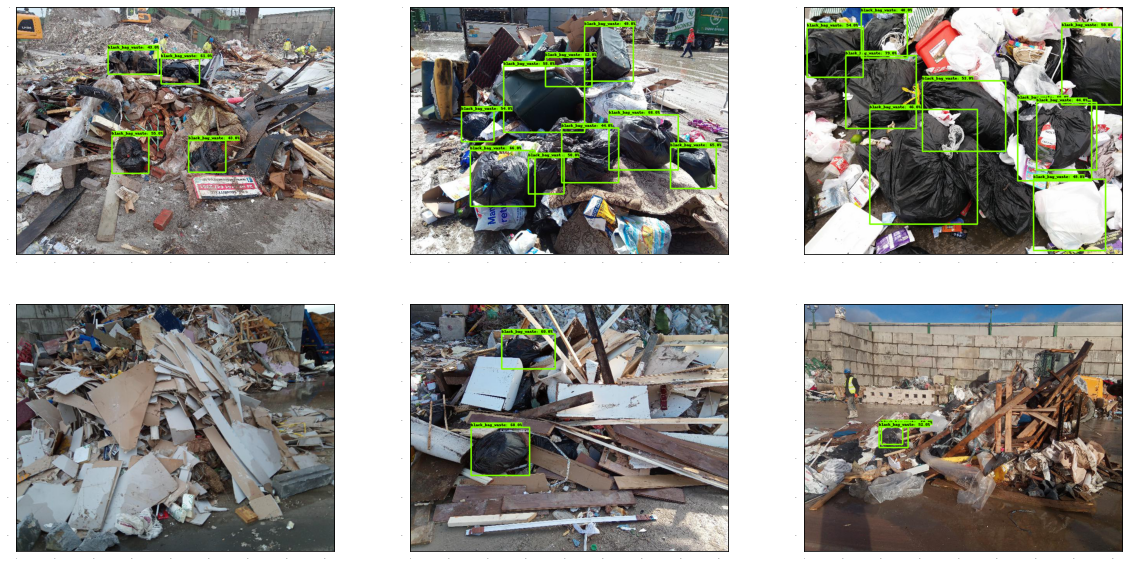

In [ ]:
plt.figure(figsize=(20,10))
for i in range(6):
  offset = 0
  input_tensor = tf.convert_to_tensor(np.expand_dims(x_test_np[i+offset], axis=0), dtype=tf.float32)
  detection = detect(input_tensor)
  plt.subplot(2, 3, i+1)
  plot_detections(
      cv2.resize(x_test_np[i+offset], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)
plt.show()



In [ ]:
tempdir = '/content/drive/My Drive/ML/'
!mv tempdir /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002
# !cp /content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002 '/content/drive/My Drive/ML/'

mv: cannot stat '/content/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-all-trained-58.data-00001-of-00002': No such file or directory


# mAP

## Detection vs gt

In [ ]:
idx = 0

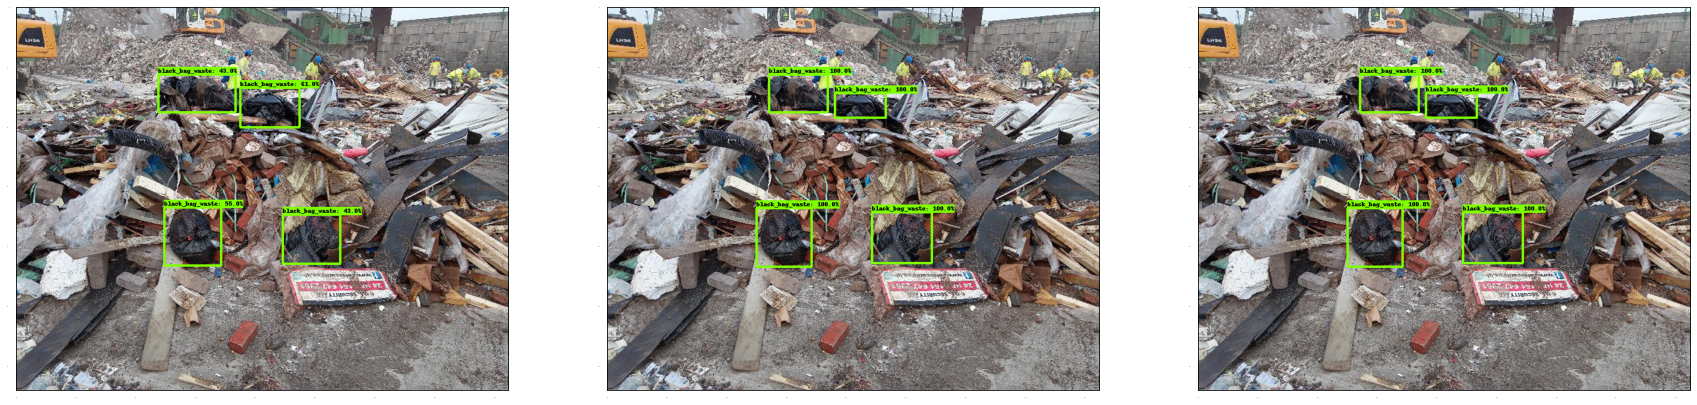

In [ ]:
# idx = 3

plt.figure(figsize=(30, 10))
detection = detect(test_image_tensors[idx])

plt.subplot(1, 3, 1)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      detection['detection_boxes'][0].numpy(),
      detection['detection_classes'][0].numpy().astype(np.uint32)
      + label_id_offset,
      detection['detection_scores'][0].numpy(),
      category_index,
      threshold = 0.4)

plt.subplot(1, 3, 2)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes[idx],
      y_test_classes[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

plt.subplot(1, 3, 3)
plot_detections(
      cv2.resize(x_test_np[idx], dsize=(824, 640), interpolation=cv2.INTER_CUBIC),
      y_test_boxes_trivial[idx],
      y_test_classes_trivial[idx],
      np.ones(shape=[y_test_classes[idx].shape[0]], dtype=np.float16),
      category_index)

idx += 1

## mAP Block

In [ ]:
# Calculate IOU 
  # There is one IOU value per box (in prediction)
  # Match to Ground truth or none

# Ground truth boxes: m x 4 np array 
# Detection boxes: 1 x 100 x 4 tensor 

# [ymin, xmin, ymax, xmax]

# xi1 = maximum of the x1 coordinates of the two boxes
# yi1 = maximum of the y1 coordinates of the two boxes
# xi2 = minimum of the x2 coordinates of the two boxes
# yi2 = minimum of the y2 coordinates of the two boxes

def iou(box1, box2):
    """Implement the intersection over union (IoU) between box1 and box2
    
    Arguments:
    box1 -- first box, list object with coordinates (box1_x1, box1_y1, box1_x2, box_1_y2)
    box2 -- second box, list object with coordinates (box2_x1, box2_y1, box2_x2, box2_y2)
    """

    # Assign variable names to coordinates for clarity
    (box1_y1, box1_x1, box1_y2, box1_x2) = box1
    (box2_y1, box2_x1, box2_y2, box2_x2) = box2
    
    # Calculate the (yi1, xi1, yi2, xi2) coordinates of the intersection of box1 and box2
    xi1 = np.maximum(box1_x1, box2_x1)
    yi1 = np.maximum(box1_y1, box2_y1)
    xi2 = np.minimum(box1_x2, box2_x2)
    yi2 = np.minimum(box1_y2, box2_y2)
    inter_width = yi2 - yi1
    inter_height = xi2 - xi1
    if inter_width < 0 or inter_height < 0:
        return 0
    inter_area = inter_width * inter_height

    # Calculate the Union area
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)
    union_area = (box1_area + box2_area) - inter_area
    
    # compute the IoU
    iou = inter_area / union_area
    
    return iou

def filter_from_score(scores, classes, boxes, threshold):
  for i, score in enumerate(scores):
    if score < threshold:
      break
  return scores[:i], classes[:i], boxes[:i]

def get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes):

  '''
    boxes: [ymin, xmin, ymax, xmax]
  '''

  ious_arr = []
  detected_which = []
  hash_table = [None] * len(gt_boxes)

  for i, (box, label) in enumerate(zip(detected_boxes, detected_classes)):
    max_iou = 0
    detected_which.append(-1)
    for j, (gt_box, gt_class) in enumerate(zip(gt_boxes, gt_classes)):
      if gt_class == label:
        iou_val = iou(gt_box, box)
        if iou_val > max_iou:
          max_iou = iou_val
          detected_which[i] = j
          if not hash_table[j]:
            hash_table[j] = (max_iou, i)
          else:
            if hash_table[j][0] < max_iou:
              detected_which[hash_table[j][1]] = -1
              hash_table[j] = (max_iou, i)
              
    ious_arr.append(max_iou)

  return ious_arr, detected_which

def get_tpfp(ious_arr, detected_which, iou_threshold = 0.5):

  tpfp = []
  for which, iou_val in zip(detected_which, ious_arr):
    if which < 0 or iou_val < iou_threshold:
      tpfp.append(0)
    else:
      tpfp.append(1) 
  
  return tpfp

def get_tpfp_list(detected_box_list, detected_class_list, detected_score_list, gt_box_list, gt_class_list, iou_threshold):
  '''
    Categorizes detections into a list of true positives and false positives in descending order of confidence level
  '''
  tpfp_list = []

  for idx in range(len(detected_score_list)):
    detected_boxes, detected_classes, detected_scores = detected_box_list[idx], detected_class_list[idx], detected_score_list[idx]

    gt_boxes = gt_box_list[idx]
    gt_classes = gt_class_list[idx]

    ious_arr, detected_which = get_ious(detected_boxes, detected_classes, gt_boxes, gt_classes)

    tpfp = get_tpfp(ious_arr, detected_which, iou_threshold=iou_threshold)

    tpfp_score_pairs = [(i, j) for i, j in zip(tpfp, detected_scores)]

    tpfp_list += tpfp_score_pairs
  
  return tpfp_list

def calculate_map(detected_box_list, 
                  detected_class_list, 
                  detected_score_list, 
                  gt_box_list, 
                  gt_class_list, 
                  num_of_classes,
                  iou_threshold = 0.5):
  '''
    calculates mAP, outputs precision and recall

    Inputs are filtered lists of detection boxes, classes, and confidence scores
    Detections have to be preprocessed and filtered based on confidence threshold

    detected_box_list: m x ? x 4
    detected_class_list: m x ?
    detected_score_list: m x ?

    gt_box_list: m x ?
    gt_class_list: m x ?

    where m is the number of samples
    ? because the number of detections and number of gt boxes is different for each sample
    all lists are lists of np arrays
  '''

  precision_list = []
  recall_list = []
  map_list = []

  for c in range(num_of_classes):
    class_eval = c + 1

    length = len(detected_box_list)
    detected_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    detected_classes_eval = [np.array([])]*length
    detected_scores_eval = [np.array([])]*length

    length = len(gt_class_list)
    gt_boxes_eval = [np.array([[0, 0, 0, 0]])]*length
    gt_classes_eval = [np.array([])]*length


    for i, detected_class in enumerate(detected_class_list):
      for j, Class in enumerate(detected_class):
        if Class == class_eval:
          detected_classes_eval[i] = np.append(detected_classes_eval[i], detected_class_list[i][j])
          detected_boxes_eval[i] = np.vstack([detected_boxes_eval[i], detected_box_list[i][j]])
          detected_scores_eval[i] = np.append(detected_scores_eval[i], detected_score_list[i][j])
      if detected_boxes_eval[i].shape[0] == 1:
        detected_boxes_eval[i] = np.array([])
      else:
        detected_boxes_eval[i] = detected_boxes_eval[i][1:]

    for i, gt_class in enumerate(gt_class_list):
      for j, Class in enumerate(gt_class):
        if Class == class_eval:
          gt_classes_eval[i] = np.append(gt_classes_eval[i], gt_class_list[i][j])
          gt_boxes_eval[i] = np.vstack([gt_boxes_eval[i], gt_box_list[i][j]])
      if gt_boxes_eval[i].shape[0] == 1:
        gt_boxes_eval[i] = np.array([])
      else:
        gt_boxes_eval[i] = gt_boxes_eval[i][1:]

    tpfp_list = get_tpfp_list(detected_boxes_eval, 
                              detected_classes_eval, 
                              detected_scores_eval, 
                              gt_boxes_eval, 
                              gt_classes_eval, 
                              iou_threshold=iou_threshold)
                              

    tpfp_list.sort(key=lambda tup: tup[1], reverse=True)

    precisions = []
    recalls = []
    tp = 0
    fp = 0

    total = 0
    for i in gt_boxes_eval:
      total += len(i)

    detection_total = 0
    for i in detected_boxes_eval:
      detection_total += len(i)

    for i, (tpfp, _) in enumerate(tpfp_list):
      if tpfp == 1:
        tp += 1
      else:
        fp += 1

      precision = tp/(tp+fp)
      if total > 0:
        recall = tp/total
      else:
        recall = 0

      precisions.append(precision)
      recalls.append(recall)

    print(f'{label_names[c+1]}: {total} annotations')
    print(f'{tp} / {detection_total} correct detections \n')
    map = np.trapz(precisions, recalls)
    precision_list.append(np.array(precisions))
    recall_list.append(np.array(recalls))
    map_list.append(map)

  return precision_list, recall_list, map_list

## mAP - Train

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in tqdm(range(len(y_train_classes))):
  detection = detect(train_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


100%|██████████| 141/141 [00:35<00:00,  3.96it/s]


In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes, 
                          y_train_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)

print('\n Trivial: ')

p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_train_boxes_trivial, 
                          y_train_classes_trivial, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)



black_bag_waste: 520 annotations
392 / 504 correct detections 

[0.623873656532565]

 Trivial: 
black_bag_waste: 389 annotations
324 / 504 correct detections 

[0.6254010065394965]


## mAP - Test

In [ ]:
detected_boxes = []
detected_classes = []
detected_scores = []

for i in range(len(y_test_classes)):
  detection = detect(test_image_tensors[i])
  detected_score, detected_class, detected_box = filter_from_score(detection['detection_scores'][0].numpy(),
                                                                  detection['detection_classes'][0].numpy()+label_id_offset,
                                                                  detection['detection_boxes'][0].numpy(),
                                                                  threshold = 0.4)
  detected_boxes.append(detected_box)
  detected_classes.append(detected_class)
  detected_scores.append(detected_score)


In [ ]:
p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes, 
                          y_test_classes, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.5)

print(map)

p, r, map = calculate_map(detected_boxes, 
                          detected_classes, 
                          detected_scores, 
                          y_test_boxes_trivial, 
                          y_test_classes_trivial, 
                          num_of_classes = num_classes,
                          iou_threshold = 0.4)

print(map)

black_bag_waste: 92 annotations
46 / 85 correct detections 

[0.3044074355367241]
black_bag_waste: 74 annotations
46 / 85 correct detections 

[0.37781539608520853]
